In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

In [3]:
class ToyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 3)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3, 2)

        self.lin1.weight = nn.Parameter(torch.arange(-4.0, 5.0).view(3, 3))
        self.lin1.bias = nn.Parameter(torch.zeros(1, 3))
        self.lin2.weight = nn.Parameter(torch.arange(-3.0, 3.0).view(2, 3))
        self.lin2.bias = nn.Parameter(torch.ones(1, 2))

    def forward(self, input):
        return self.lin2(self.relu(self.lin1(input)))

In [4]:
model = ToyModel()
model.eval()

ToyModel(
  (lin1): Linear(in_features=3, out_features=3, bias=True)
  (relu): ReLU()
  (lin2): Linear(in_features=3, out_features=2, bias=True)
)

In [5]:
torch.manual_seed(123)
np.random.seed(123)

In [6]:
input = torch.rand(2, 3)
baseline = torch.zeros(2, 3)

In [7]:
ig = IntegratedGradients(model)
attr, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)
print('IG Attributions:', attr)
print('Convergence Delta:', delta)

IG Attributions: tensor([[-0.5922, -1.5497, -1.0067],
        [ 0.0000, -0.2219, -5.1991]], dtype=torch.float64)
Convergence Delta: tensor([5.9605e-08, 0.0000e+00], dtype=torch.float64)


In [8]:
# Titanic Data Analysis

In [51]:
import numpy as np
import scipy.stats
import pandas as pd
import torch
import captum.attr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
dataset_path = '~/.keras/datasets/titanic3.csv'
titanic_data = pd.read_csv(dataset_path)

In [54]:
titanic_data = pd.concat([titanic_data, pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'], prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'], prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest', 'sex', 'embarked', 'pclass'], axis=1)

In [55]:
np.random.seed(131254)

labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

train_indices = np.random.choice(len(labels), int(0.7 * len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [56]:
import torch
import torch.nn as nn
torch.manual_seed(1)
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [57]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('/Users/dlee/.keras/datasets/titanic_model.pt'))
    print("Model Loaded!")
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)

Model Loaded!


In [58]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8493449781659389


In [59]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.816793893129771


In [60]:
ig = captum.attr.IntegratedGradients(net)

In [62]:
test_input_tensor.requires_grad_()
attrs, delta = ig.attribute(test_input_tensor, target=1, return_convergence_delta=True)
attr = attrs.detach().numpy()

In [63]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

Average Feature Importances
age :  -0.454
sibsp :  -0.119
parch :  -0.056
fare :  0.175
female :  0.154
male :  -0.359
embark_C :  0.086
embark_Q :  -0.001
embark_S :  -0.082
class_1 :  0.062
class_2 :  0.021
class_3 :  -0.159


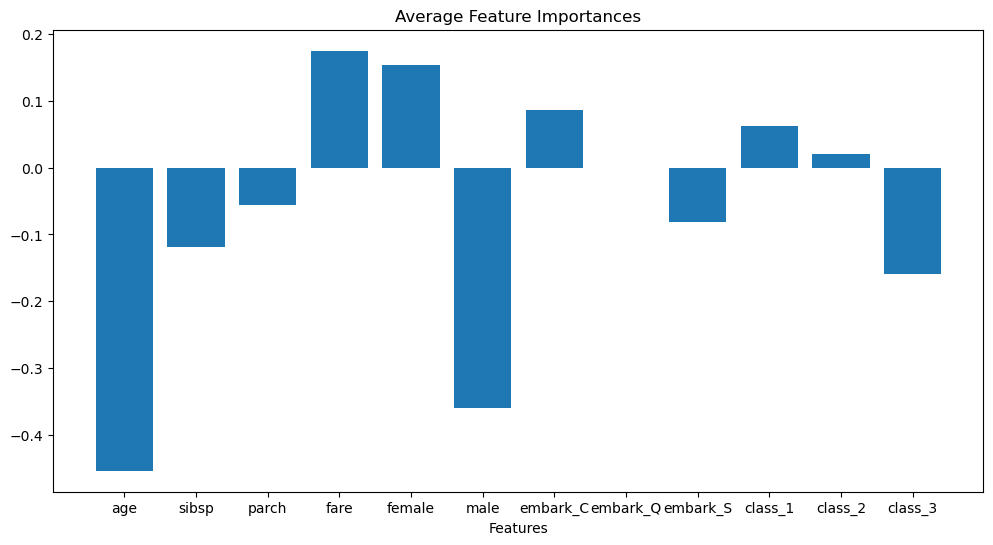

In [64]:
visualize_importances(feature_names, np.mean(attr, axis=0))

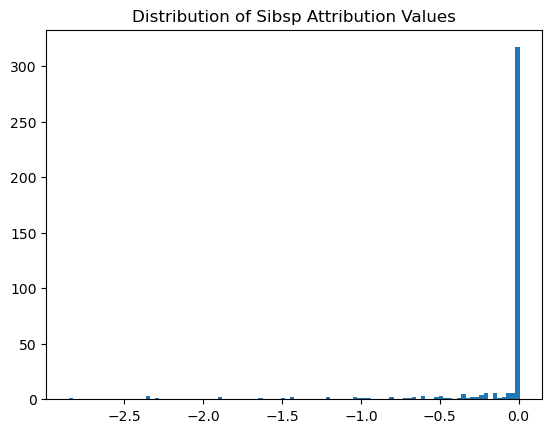

In [65]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

In [66]:
attr.shape

(393, 12)

In [82]:
input_tensor.shape, label_tensor.shape, test_input_tensor.shape, test_labesl.shape

(torch.Size([916, 12]), torch.Size([916]), torch.Size([393, 12]), (393,))

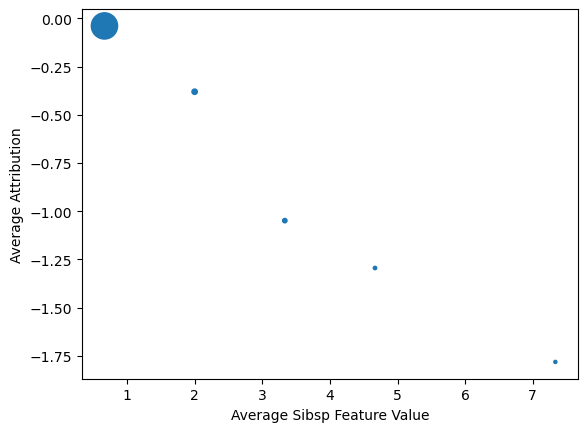

In [85]:
bin_means, bin_edges, _ = scipy.stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = scipy.stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

In [87]:
cond = captum.attr.LayerConductance(net, net.sigmoid1)

In [89]:
cond_vals = cond.attribute(test_input_tensor, target=1)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  -0.123
1 :  -0.040
2 :  0.030
3 :  0.012
4 :  -0.022
5 :  -0.137
6 :  0.009
7 :  0.001
8 :  -0.136
9 :  -0.000
10 :  -0.306
11 :  0.016


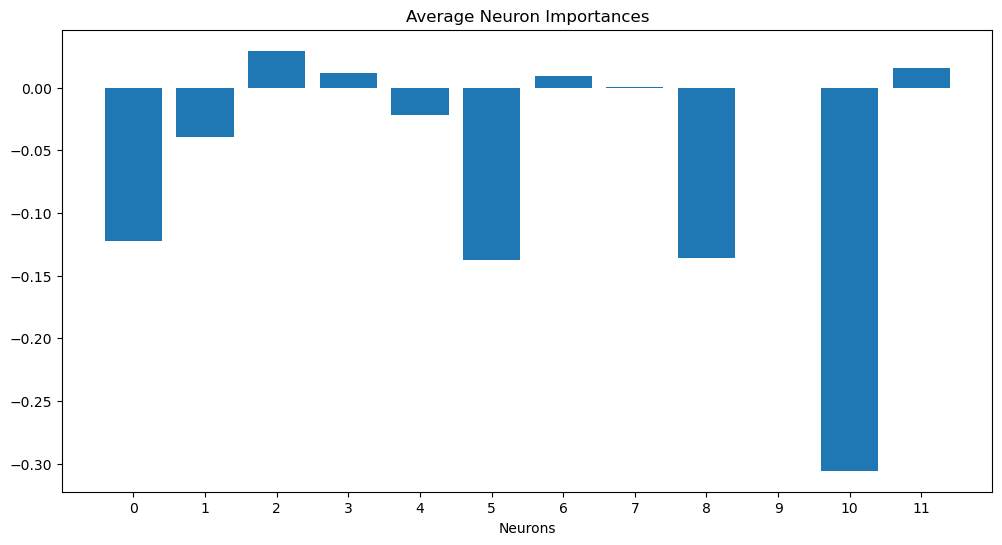

In [91]:
visualize_importances(range(12),
                      np.mean(cond_vals, axis=0),
                      title='Average Neuron Importances',
                      axis_title='Neurons')

In [92]:
cond_vals.shape

(393, 12)

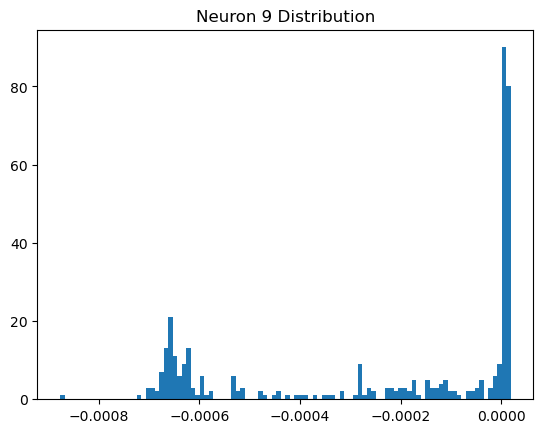

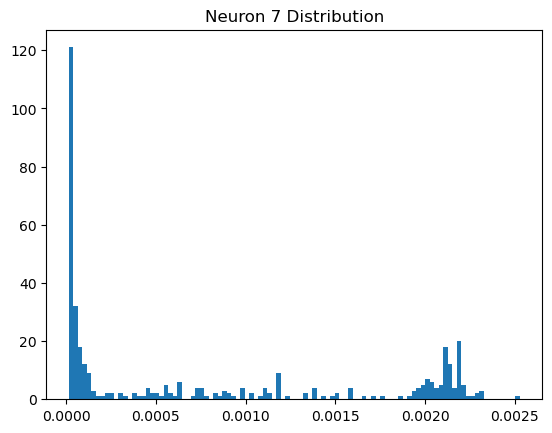

In [97]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");

In [98]:
neuron_cond = captum.attr.NeuronConductance(net, net.sigmoid1)

In [101]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_selector=10, target=1)
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)
neuron_cond_vals_10.shape, neuron_cond_vals_0.shape

(torch.Size([393, 12]), torch.Size([393, 12]))

Average Feature Importances for Neuron 0
age :  -0.128
sibsp :  -0.004
parch :  0.003
fare :  0.003
female :  0.000
male :  0.001
embark_C :  0.006
embark_Q :  -0.000
embark_S :  -0.004
class_1 :  0.002
class_2 :  0.007
class_3 :  -0.019


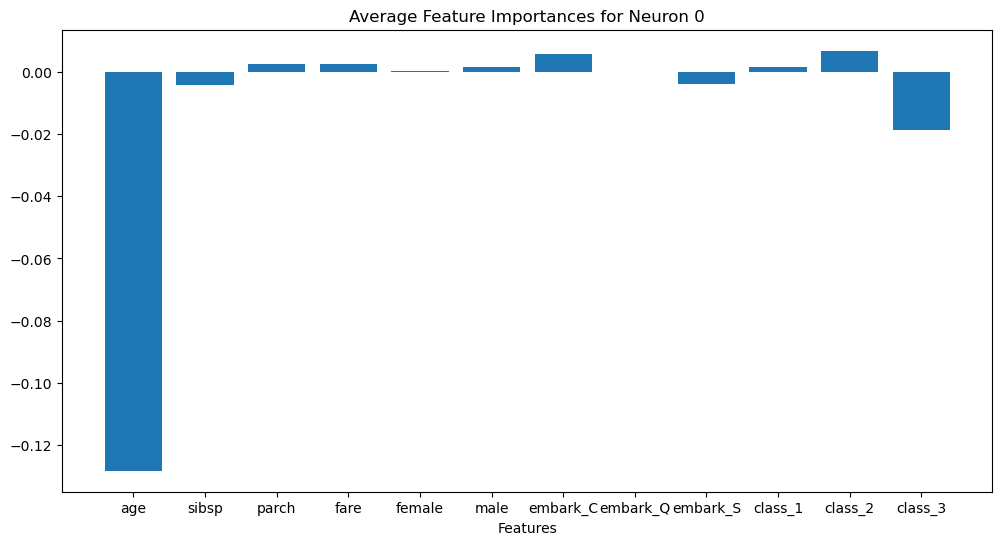

In [102]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

Average Feature Importances for Neuron 0
age :  -0.012
sibsp :  0.003
parch :  0.000
fare :  -0.015
female :  0.055
male :  -0.210
embark_C :  0.016
embark_Q :  -0.006
embark_S :  -0.052
class_1 :  0.022
class_2 :  0.009
class_3 :  -0.116


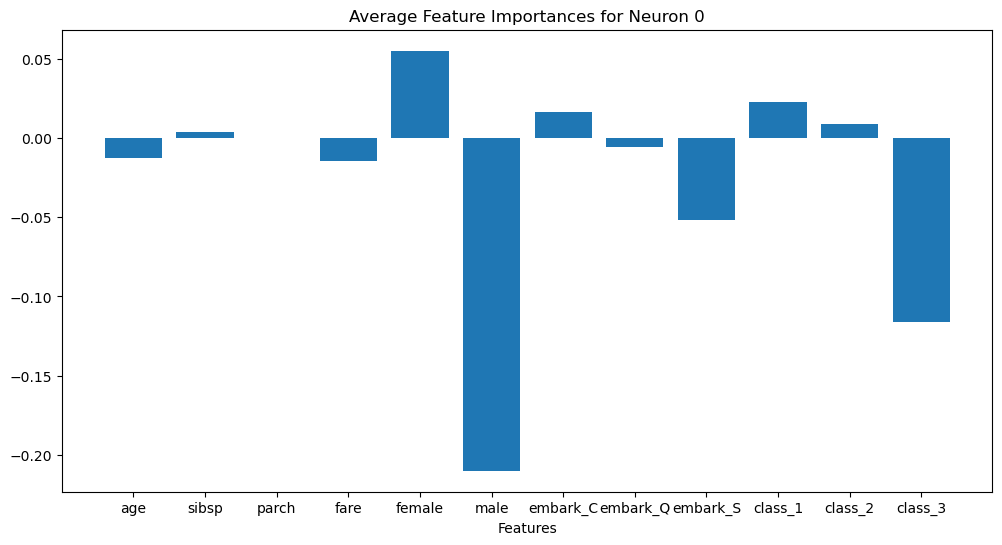

In [103]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")